# Evaluate generated music
- Empty bars
- Avg pitch classes

In [1]:
# !pip install music21

In [1]:
import music21 as m21
from collections import Counter
from scipy.stats import entropy
import numpy as np
import pandas as pd

import os

In [11]:
def get_file_metrics(part, key, scale):
    
    # Initialize metrics
    total_empty_bars = 0
    pitch_counts = []
    pitch_entropies = [0]*4
    # chord_frequencies = []
    melody_pitches = [{}]*4

    measures = part.getElementsByClass(m21.stream.Measure)
    total_bars = len(measures)
    
    part_name = measures[0].getInstruments()[0].partName
    # print(f"part name: {part_name}")
    
    # # Analyze chords in the measure
    # chords_in_measure = measures.chordify()
    # measure_chord_frequencies = {f'{i}': 0 for i in ["i", "ii", "iii", "iv", "v", "vi", "vii"]}
    # for chord in chords_in_measure.recurse().getElementsByClass('Chord'):
    #     roman = m21.roman.romanNumeralFromChord(chord, key)
    #     # print(roman.figure)
    #     if roman.figure in measure_chord_frequencies:
    #         measure_chord_frequencies[roman.figure] += 1
    # chord_frequencies.append(measure_chord_frequencies)
    
    # print(f"there are {len(measures)} measures")

    for measure in measures:
        # print(f"processing measure number {measure.measureNumber}, offset {measure.offset}")
        measure_idx = measure.measureNumber - 1
        notes = measure.notes
        voices = measure.voices
        if len(voices) > 0:
            notes_in_voices = [note for voice in voices for note in voice.notes]
        else:
            notes_in_voices = []
        
        if len(notes) + len(notes_in_voices) == 0:
            total_empty_bars += 1
        else:
            # Collect unique pitch classes in the measure (ignoring octave differences)
            note_pitches = [note for note in notes if note.isNote]
            # note_pitch_classes = [note.pitch.pitchClass for note in notes if note.isNote]
            
            voice_note_pitches = [note for note in notes_in_voices if note.isNote]
            # voice_note_pitch_classes = [note.pitch.pitchClass for note in notes_in_voices if note.isNote]
            # print(f"unique pitches in voices: {voice_note_pitch_classes}")
            voice_chords_pitches = [note for chord in notes_in_voices if chord.isChord for note in chord.notes]
            # voice_chords_pitch_classes = [note.pitch.pitchClass for chord in notes_in_voices if chord.isChord for note in chord.notes]
            # print(f"unique pitches in voice chords: {voice_chords_pitch_classes}")
            
            measure_notes = note_pitches + voice_note_pitches + voice_chords_pitches
            measure_pitch_classes = [note.pitch.pitchClass for note in measure_notes]
            
            
            # unique_pitch_classes = set(note_pitch_classes + voice_note_pitch_classes + voice_chords_pitch_classes)
            unique_pitch_classes = set(measure_pitch_classes)
            # print(f"unique pitches in bar: {unique_pitch_classes}")
            pitch_counts.append(len(unique_pitch_classes))
            
            
            # Calculate entropy of pitches in the measure
            pitch_counter = Counter(note.pitch.midi for note in measure_notes)
            pitch_probs = np.array(list(pitch_counter.values())) / sum(pitch_counter.values())
            if not pitch_probs.all():
                print(f"pitch_probs empty, notes: {measure_notes}")
            pitch_entropies[measure_idx] = entropy(pitch_probs)
            
            # # Analyze chords in the measure
            # chords_in_measure = measure.chordify()
            # measure_chord_frequencies = {f'{i}': 0 for i in ["i", "ii", "iii", "iv", "v", "vi", "vii"]}
            # for chord in chords_in_measure.recurse().getElementsByClass('Chord'):
            #     roman = m21.roman.romanNumeralFromChord(chord, key)
            #     # print(roman.figure)
            #     if roman.figure in measure_chord_frequencies:
            #         measure_chord_frequencies[roman.figure] += 1
            # chord_frequencies.append(measure_chord_frequencies)
            
            if part_name == 'Melody':
                # Identify melody pitches in context of I chord
                melody_pitch_set = set()
                tonic_pitch_class = key.tonic.pitchClass
                melody_pitch_count = {f'{i+1}': 0 for i in range(0, 7)}
                for note in notes:
                    if note.isChord:
                        curr_notes = note.notes
                    else:
                        curr_notes = [note]
                    
                    for curr_note in curr_notes:
                        scale_degree = scale.getScaleDegreeFromPitch(curr_note.pitch)
                        if scale_degree and 1 <= scale_degree <= 7:
                            melody_pitch_count[str(scale_degree)] += 1
                            # melody_pitch_set.add(scale_degree)
                melody_pitches[measure_idx] = melody_pitch_count
    
    # Ratio of empty bars
    empty_bar_ratio = total_empty_bars / total_bars
    # Calculate average number of pitch classes per bar
    avg_pitch_classes_per_bar = sum(pitch_counts) / total_bars if total_bars > 0 else 0
        
    
    return part_name, {
        "empty_bar_ratio": empty_bar_ratio,
        "apc_per_bar": avg_pitch_classes_per_bar,
        "pitch_entropies": pitch_entropies,
        # "chord_freq": chord_frequencies,
        "melody_pitches": melody_pitches,
    }

def get_metrics(midi_file_path):
    # Load the MIDI file using music21
    score = m21.converter.parse(midi_file_path)
    
    # Determine the key signature
    key = score.analyze('key')
    scale = key.getScale()
    
    # Get the parts (tracks) of the score
    parts = score.parts
    # print(f"score has {len(parts)} parts")
    
    metrics_all = {"chord_freqs": [{}]*4}
    
    # chord_frequencies = []
    chords = score.chordify()
    for chords_in_measure in chords:
        measure_idx = chords_in_measure.measureNumber - 1
        measure_chord_frequencies = {f'{i}': 0 for i in ["i", "ii", "iii", "iv", "v", "vi", "vii"]}
        for chord in chords_in_measure.recurse().getElementsByClass('Chord'):
            roman = m21.roman.romanNumeralFromChord(chord, key)
            # print(roman.figure)
            if roman.figure in measure_chord_frequencies:
                measure_chord_frequencies[roman.figure] += 1
        metrics_all["chord_freqs"][measure_idx] = measure_chord_frequencies
    
    for part in parts:
        part_name, metrics = get_file_metrics(part, key, scale)
        metrics_all[part_name] = metrics
        
    return metrics_all



def get_track_metrics(track_metrics):

        
    df = pd.DataFrame(track_metrics)
    # print(df)
    empty_bar_ratio = df.empty_bar_ratio.mean()
    apc_per_bar = df.apc_per_bar.mean()
    pitch_entropies_per_bar = pd.DataFrame(df.pitch_entropies.tolist()).mean().values
    
    # print(track_metrics['chord_freqs'])
    # all_chord_merge = [d for track_metric in track_metrics['chord_freqs'] for d in track_metric]
    # chord_freq_all = pd.DataFrame(all_chord_merge).sum().to_dict()
    
    melody_pitches_per_bar = pd.DataFrame(df.melody_pitches.tolist())
    melody_pitch_all = melody_pitches_per_bar.apply(lambda x: pd.DataFrame([p for p in x.tolist() if p]).sum().to_dict(), axis=0)

    return empty_bar_ratio, apc_per_bar, pitch_entropies_per_bar, melody_pitch_all

In [42]:
def get_all_metrics(file_dir):
    
    files = os.listdir(file_dir)

    track_metrics = {
        "melody": [],
        "bridge": [],
        "piano": [],
        "chord_freqs":[],
    }
    

    for file in files:
        midi_file_path = f"{file_dir}/{file}/generated.mid"
        # midi_file_path = f"{file_dir}/{file}/{file}.mid"
        print(f"processing {midi_file_path}")
        file_metrics = get_metrics(midi_file_path)
        # print(file_metrics)
    
        for track_name, file_track_metric in file_metrics.items():
            track_metrics[track_name.lower()].append(file_track_metric)
            
    # return track_metrics

    metrics_avg = {}
    # print(track_metrics)
    for track_name, metrics in track_metrics.items():
        if track_name == 'chord_freqs':
            # print(metrics)
            all_chord_merge = pd.DataFrame(metrics)
            chord_freq_all = all_chord_merge.apply(lambda x: pd.DataFrame([p for p in x.tolist() if p]).sum().to_dict(), axis=0)

    
    
            # all_chord_merge = [d for track_metric in track_metrics['chord_freqs'] for d in track_metric]
            # chord_freq_all = pd.DataFrame(all_chord_merge).sum().to_dict()
            metrics_avg[track_name] = chord_freq_all
        else:
            print(metrics)
            empty_bar_ratio, apc_per_bar, pitch_entropies_per_bar, melody_pitch_all = get_track_metrics(metrics)
            metrics_avg[track_name] = {
                "empty_bar_ratio": empty_bar_ratio,
                "apc_per_bar": apc_per_bar,
                "pitch_entropies_per_bar": pitch_entropies_per_bar,
                "melody_pitch_all": melody_pitch_all,
            }
        
    # all_chord_merge = [d for track_metric in track_metrics['chord_freqs'] for d in track_metric]
    # chord_freq_all = pd.DataFrame(all_chord_merge).sum().to_dict()

    return metrics_avg

In [13]:
track_metrics = get_all_metrics("music_POP8_4_150_kld_anneal")

processing music_POP8_4_150_kld_anneal/6/generated.mid
processing music_POP8_4_150_kld_anneal/56/generated.mid
processing music_POP8_4_150_kld_anneal/98/generated.mid
processing music_POP8_4_150_kld_anneal/52/generated.mid
processing music_POP8_4_150_kld_anneal/10/generated.mid
processing music_POP8_4_150_kld_anneal/72/generated.mid
processing music_POP8_4_150_kld_anneal/99/generated.mid
processing music_POP8_4_150_kld_anneal/45/generated.mid
processing music_POP8_4_150_kld_anneal/3/generated.mid
processing music_POP8_4_150_kld_anneal/17/generated.mid
processing music_POP8_4_150_kld_anneal/48/generated.mid
processing music_POP8_4_150_kld_anneal/96/generated.mid
processing music_POP8_4_150_kld_anneal/46/generated.mid
processing music_POP8_4_150_kld_anneal/60/generated.mid
processing music_POP8_4_150_kld_anneal/65/generated.mid
processing music_POP8_4_150_kld_anneal/40/generated.mid
processing music_POP8_4_150_kld_anneal/58/generated.mid
processing music_POP8_4_150_kld_anneal/34/generate

In [14]:
import matplotlib.pyplot as plt

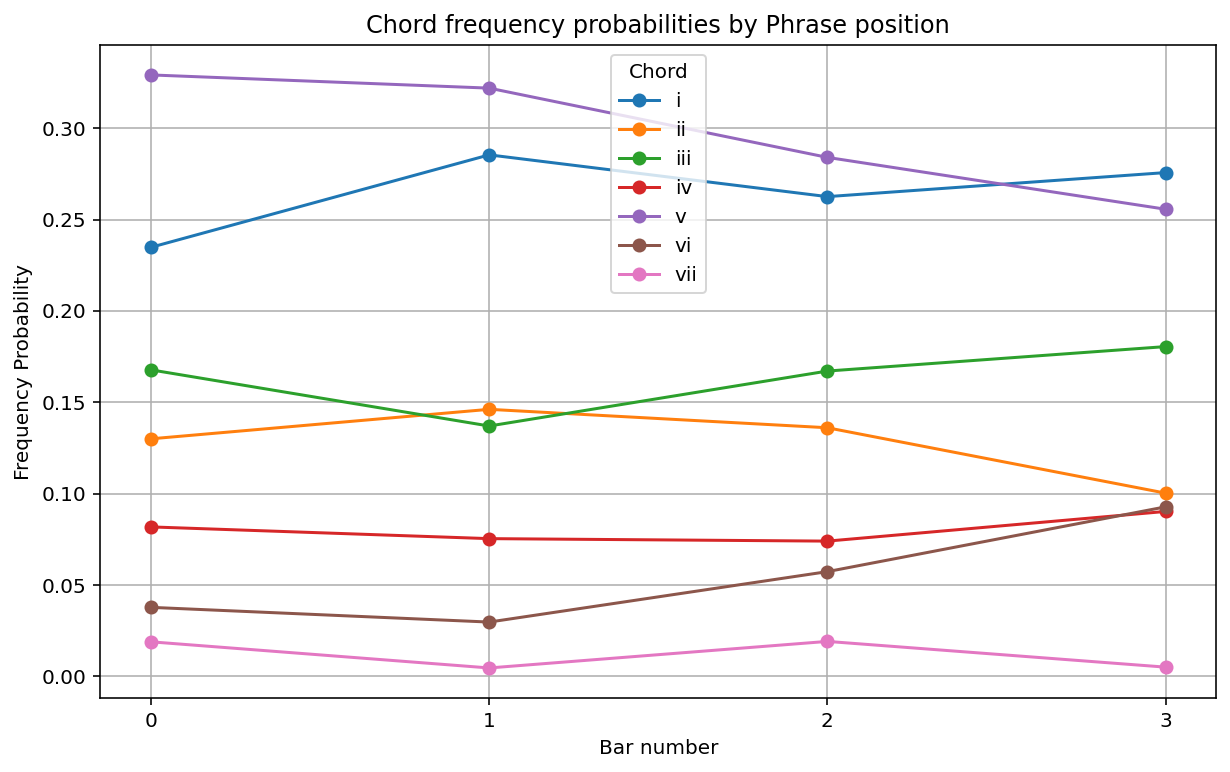

In [34]:
chords_df= pd.DataFrame(track_metrics['chord_freqs'].to_list())
# Normalize the counts by row
df_normalized = chords_df.div(chords_df.sum(axis=1), axis=0)

# Plot the normalized counts
plt.figure(figsize=(10, 6))
for column in df_normalized.columns:
    plt.plot(df_normalized.index, df_normalized[column], marker='o', label=column)

plt.title('Chord frequency probabilities by Phrase position')
plt.xlabel('Bar number')
plt.ylabel('Frequency Probability')
plt.xticks([0, 1, 2, 3])
plt.legend(title='Chord')
plt.grid(True)
plt.show()

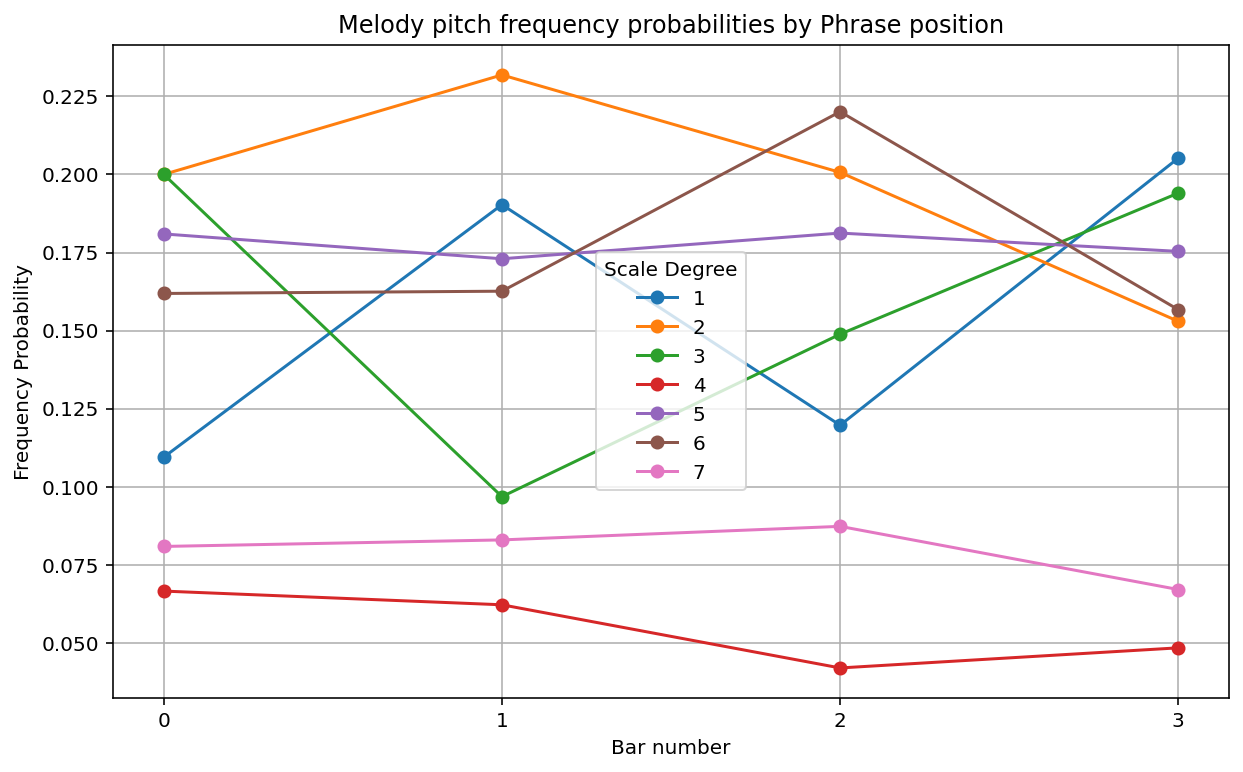

In [35]:
melody_df = pd.DataFrame(track_metrics['melody']['melody_pitch_all'].tolist())

# Normalize the counts by row
melody_df_norm = melody_df.div(melody_df.sum(axis=1), axis=0)

# Plot the normalized counts
plt.figure(figsize=(10, 6))
for column in melody_df_norm.columns:
    plt.plot(melody_df_norm.index, melody_df_norm[column], marker='o', label=column)

plt.title('Melody pitch frequency probabilities by Phrase position')
plt.xlabel('Bar number')
plt.ylabel('Frequency Probability')
plt.xticks([0, 1, 2, 3])
plt.legend(title='Scale Degree')
plt.grid(True)
plt.show()

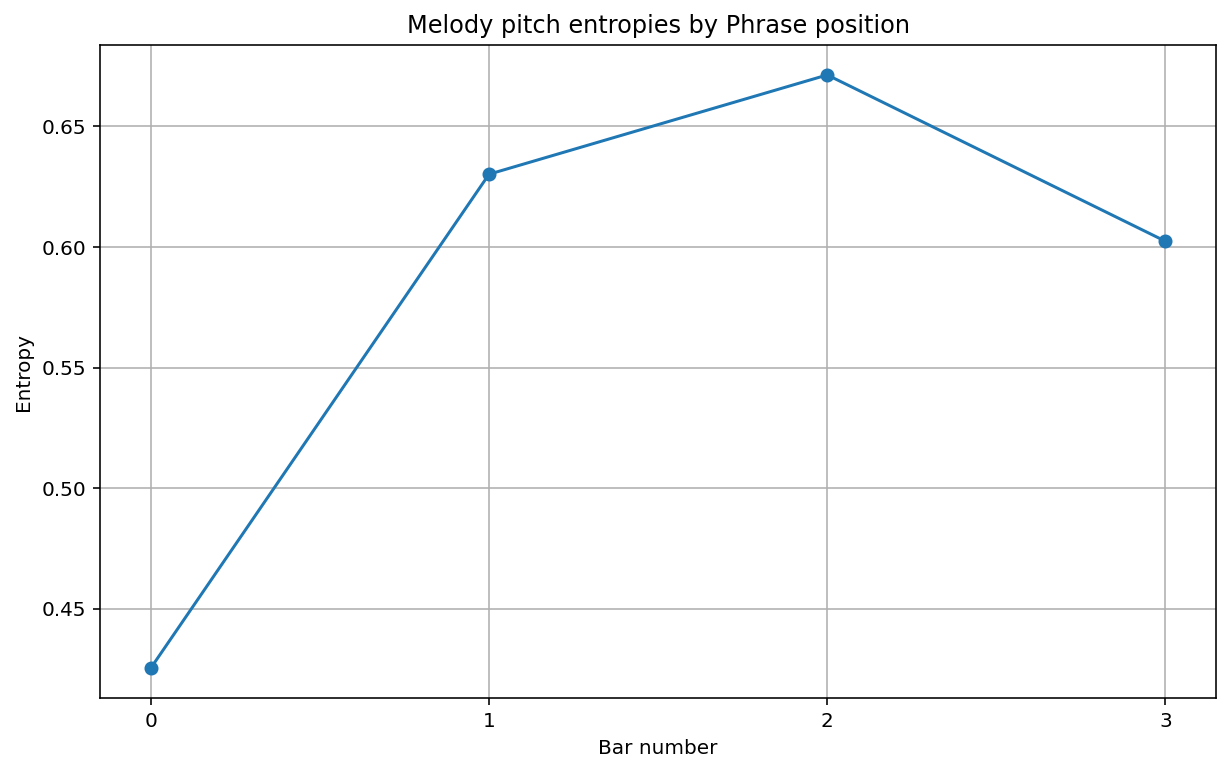

In [37]:
# Plot the normalized counts
plt.figure(figsize=(10, 6))
# for column in melody_df_norm.columns:
plt.plot(track_metrics['melody']['pitch_entropies_per_bar'], marker='o', label=column)

plt.title('Melody pitch entropies by Phrase position')
plt.xlabel('Bar number')
plt.xticks([0, 1, 2, 3])
plt.ylabel('Entropy')
# plt.legend(title='Scale Degree')
plt.grid(True)
plt.show()

In [18]:
track_metrics.keys()

dict_keys(['melody', 'bridge', 'piano', 'chord_freqs'])

In [23]:
track_metrics['melody'].keys()

dict_keys(['empty_bar_ratio', 'apc_per_bar', 'pitch_entropies_per_bar', 'melody_pitch_all'])

In [20]:
track_metrics['melody']['empty_bar_ratio']

0.09848484848484848

In [21]:
track_metrics['bridge']['empty_bar_ratio']

0.2183908045977011

In [22]:
track_metrics['piano']['empty_bar_ratio']

0.0125

In [24]:
track_metrics['melody']['apc_per_bar']

2.0336700336700337

In [25]:
track_metrics['bridge']['apc_per_bar']

1.3860153256704981

In [26]:
track_metrics['piano']['apc_per_bar']

3.331666666666667

In [43]:
pop909_metrics = get_all_metrics("POP909_phrases")

processing POP909_phrases/5101/generated.mid
processing POP909_phrases/1342/generated.mid
processing POP909_phrases/2900/generated.mid
processing POP909_phrases/5520/generated.mid
processing POP909_phrases/4493/generated.mid
processing POP909_phrases/3923/generated.mid
processing POP909_phrases/3407/generated.mid
processing POP909_phrases/3854/generated.mid
processing POP909_phrases/5768/generated.mid
processing POP909_phrases/295/generated.mid
processing POP909_phrases/3768/generated.mid
processing POP909_phrases/3252/generated.mid
processing POP909_phrases/6096/generated.mid
processing POP909_phrases/1870/generated.mid
processing POP909_phrases/6990/generated.mid
processing POP909_phrases/2917/generated.mid
processing POP909_phrases/2371/generated.mid
processing POP909_phrases/4818/generated.mid
processing POP909_phrases/5535/generated.mid
processing POP909_phrases/183/generated.mid
processing POP909_phrases/5213/generated.mid
processing POP909_phrases/4662/generated.mid
processing P

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[{'empty_bar_ratio': 0.0, 'apc_per_bar': 4.25, 'pitch_entropies': [1.5607104090414068, 1.945910149055314, 2.1972245773362196, 1.5229550675313182], 'melody_pitches': [{}, {}, {}, {}]}, {'empty_bar_ratio': 0.0, 'apc_per_bar': 5.5, 'pitch_entropies': [1.9686932085049353, 1.9600951351245584, 2.12020822394067, 2.363921103283949], 'melody_pitches': [{}, {}, {}, {}]}, {'empty_bar_ratio': 0.0, 'apc_per_bar': 5.5, 'pitch_entropies': [2.4254797084327193, 2.2781179623110317, 2.3439329813080194, 2.252728336819822], 'melody_pitches': [{}, {}, {}, {}]}, {'empty_bar_ratio': 0.0, 'apc_per_bar': 6.25, 'pitch_entropies': [2.4410152780267027, 2.3947004058583334, 2.5577938601077324, 2.3034884952192693], 'melody_pitches': [{}, {}, {}, {}]}, {'empty_bar_ratio': 0.0, 'apc_per_bar': 5.5, 'pitch_entropies': [2.363921103283949, 2.009709181894145, 1.9869667702348364, 2.0692024658203625], 'melody_pitches': [{}, {}, {}, {}]}, {'empty_bar_ratio': 0.0, 'apc_per_bar': 5.5, 'pitch_entropies': [2.3025850929940455, 2.24

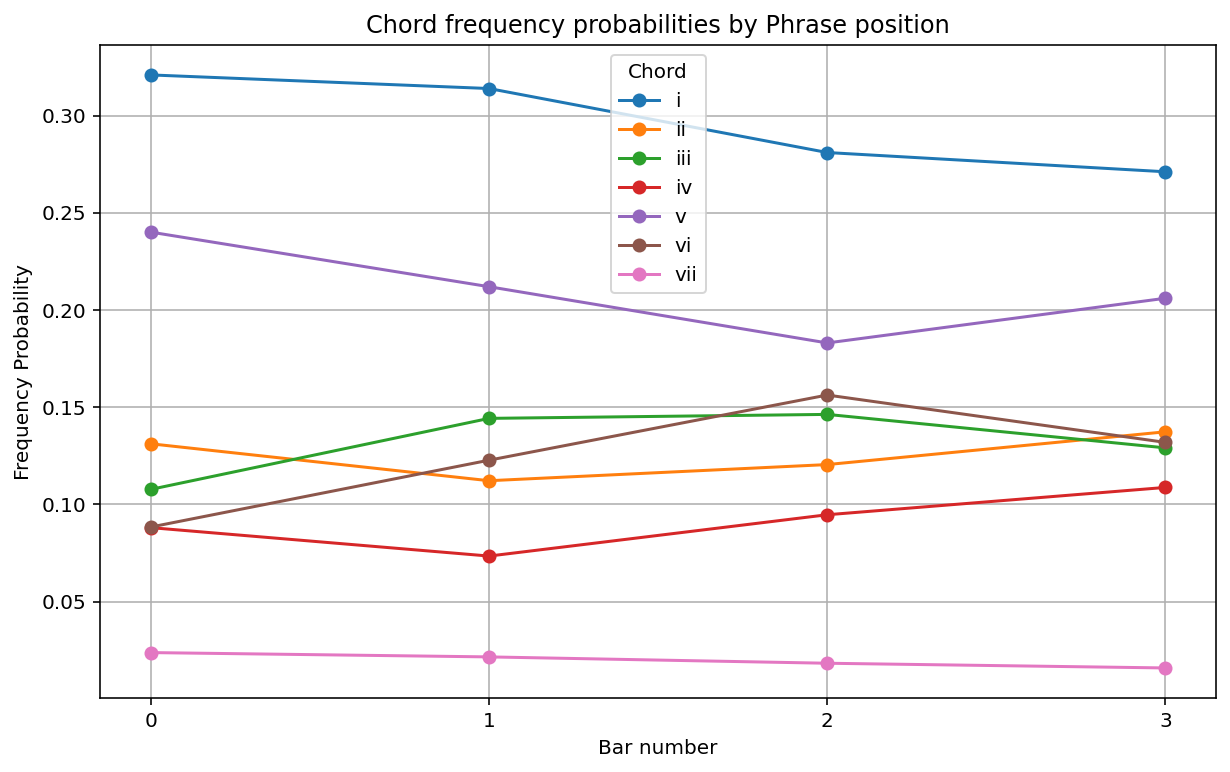

In [44]:
chords_df= pd.DataFrame(pop909_metrics['chord_freqs'].to_list())
# Normalize the counts by row
df_normalized = chords_df.div(chords_df.sum(axis=1), axis=0)

# Plot the normalized counts
plt.figure(figsize=(10, 6))
for column in df_normalized.columns:
    plt.plot(df_normalized.index, df_normalized[column], marker='o', label=column)

plt.title('Chord frequency probabilities by Phrase position')
plt.xlabel('Bar number')
plt.ylabel('Frequency Probability')
plt.xticks([0, 1, 2, 3])
plt.legend(title='Chord')
plt.grid(True)
plt.show()

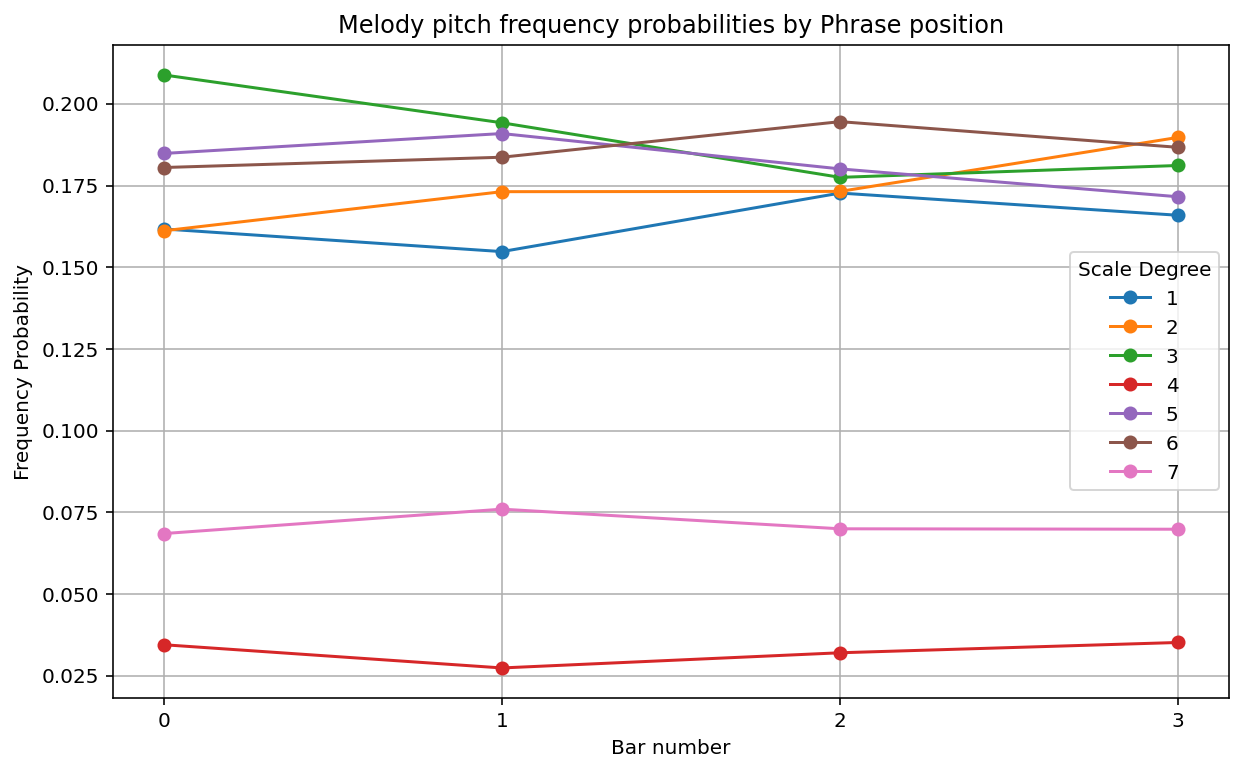

In [45]:
melody_df = pd.DataFrame(pop909_metrics['melody']['melody_pitch_all'].tolist())

# Normalize the counts by row
melody_df_norm = melody_df.div(melody_df.sum(axis=1), axis=0)

# Plot the normalized counts
plt.figure(figsize=(10, 6))
for column in melody_df_norm.columns:
    plt.plot(melody_df_norm.index, melody_df_norm[column], marker='o', label=column)

plt.title('Melody pitch frequency probabilities by Phrase position')
plt.xlabel('Bar number')
plt.ylabel('Frequency Probability')
plt.xticks([0, 1, 2, 3])
plt.legend(title='Scale Degree')
plt.grid(True)
plt.show()

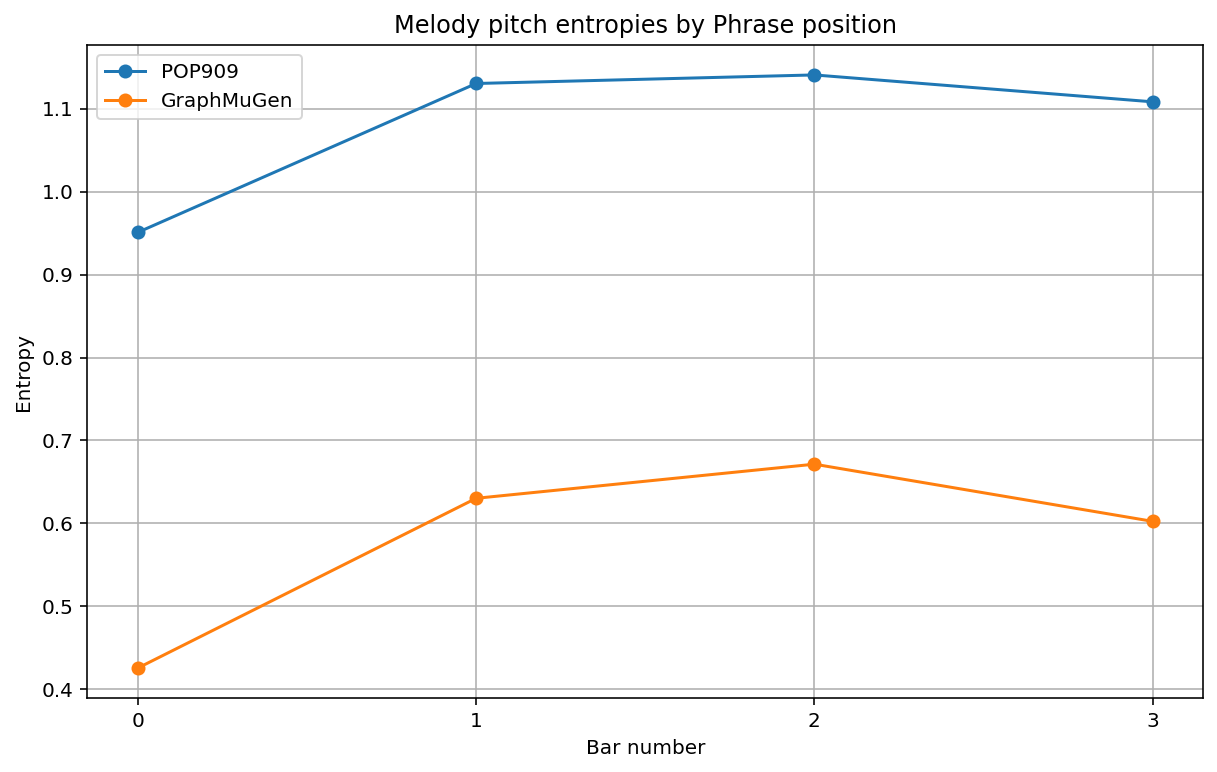

In [50]:
# Plot the normalized counts
plt.figure(figsize=(10, 6))
# for column in melody_df_norm.columns:
plt.plot(pop909_metrics['melody']['pitch_entropies_per_bar'], marker='o', label=column)
plt.plot(track_metrics['melody']['pitch_entropies_per_bar'], marker='o', label=column)

plt.title('Melody pitch entropies by Phrase position')
plt.xlabel('Bar number')
plt.xticks([0, 1, 2, 3])
plt.ylabel('Entropy')
plt.legend(["POP909", "GraphMuGen"])
plt.grid(True)
plt.show()

In [47]:
for track, metrics in track_metrics.items():
    if track != 'chord_freqs':
        print(f"track: {track} | empty_bar_ratio: {metrics['empty_bar_ratio']}, apc_per_bar: {metrics['apc_per_bar']}")

track: melody | empty_bar_ratio: 0.09848484848484848, apc_per_bar: 2.0336700336700337
track: bridge | empty_bar_ratio: 0.2183908045977011, apc_per_bar: 1.3860153256704981
track: piano | empty_bar_ratio: 0.0125, apc_per_bar: 3.331666666666667


In [51]:
for track, metrics in pop909_metrics.items():
    if track != 'chord_freqs':
        print(f"track: {track} | empty_bar_ratio: {metrics['empty_bar_ratio']}, apc_per_bar: {metrics['apc_per_bar']}")

track: melody | empty_bar_ratio: 0.010115938044175602, apc_per_bar: 3.328773714599945
track: bridge | empty_bar_ratio: 0.04686783979470259, apc_per_bar: 2.6260998075336817
track: piano | empty_bar_ratio: 0.00037805883970305196, apc_per_bar: 4.679050957749061


In [155]:
import pandas as pd

In [158]:
metrics = get_metrics(midi_file_path)
df = pd.DataFrame(metrics)
df.empty_bar_ratio.mean()
df.apc_per_bar.mean()

3.1666666666666665

In [7]:

# Example usage:
midi_file_path = "music_POP8_4_150_kld_anneal/40/generated.mid"
# metrics = calculate_metrics(midi_file_path)
# print("Empty Bars:", metrics["Empty Bars"])
# print("Average Pitch Classes per Bar:", metrics["Average Pitch Classes per Bar"])

In [8]:
score = m21.converter.parse(midi_file_path)

In [69]:
c = score.chordify()

In [75]:
c.getElementsByClass(m21.stream.Measure)[0].show('text')

{0.0} <music21.instrument.Piano 'Melody: Piano'>
{0.0} <music21.clef.TrebleClef>
{0.0} <music21.meter.TimeSignature 4/4>
{0.0} <music21.note.Rest 2.5ql>
{2.5} <music21.chord.Chord G4>
{2.75} <music21.note.Rest 1.25ql>


In [77]:
c[0].measureNumber

1

In [9]:
parts = score.parts

In [10]:
parts.show('text')

{0.0} <music21.stream.Part 0x7f672b8f4e10>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.instrument.Piano 'Melody: Piano'>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.note.Rest whole>
    {4.0} <music21.stream.Measure 2 offset=4.0>
        {0.0} <music21.note.Rest dotted-eighth>
        {0.75} <music21.note.Note B>
        {1.4167} <music21.note.Rest 16th>
        {1.6667} <music21.note.Note A>
        {1.9167} <music21.note.Rest 4/3ql>
        {3.25} <music21.note.Note A>
        {3.5} <music21.note.Rest eighth>
    {8.0} <music21.stream.Measure 3 offset=8.0>
        {0.0} <music21.note.Rest whole>
    {12.0} <music21.stream.Measure 4 offset=12.0>
        {0.0} <music21.note.Rest 1/3ql>
        {0.3333} <music21.note.Note E>
        {0.5833} <music21.note.Rest 7/6ql>
        {1.75} <music21.chord.Chord F4 B4>
        {2.0} <music21.note.Rest half>
        {4.0} <music21.bar.Barline type=final>


In [5]:
measures = parts[2].getElementsByClass(m21.stream.Measure)

In [48]:
chords[3].show('text')

{0.0} <music21.chord.Chord G#2 E-3 G#3 G#4 E5>
{0.25} <music21.chord.Chord G#2 E-3 G#4>
{0.5} <music21.chord.Chord G#2 G#3 G#4>
{0.75} <music21.chord.Chord G#4>
{1.0} <music21.chord.Chord F#2 F#3 B-3 G#4 A4>
{1.1667} <music21.chord.Chord F#2 F#3 B-3 A4>
{1.5} <music21.chord.Chord F#2 C#3 F#3 B-3 A4>
{1.6667} <music21.chord.Chord F#2 C#3 A4>
{2.0} <music21.chord.Chord F#2 C#3 C#4 A4>
{2.25} <music21.chord.Chord F#2 C#3 A4>
{2.5} <music21.chord.Chord F#2 F#3 A4 C#5>
{2.6667} <music21.chord.Chord F#3 A4 C#5>
{2.75} <music21.chord.Chord A4>
{3.0} <music21.chord.Chord F#4 G#4 A4>
{3.25} <music21.chord.Chord A4>
{3.5} <music21.chord.Chord F#3 F#4 A4>
{3.75} <music21.chord.Chord F#3 A4>
{3.8333} <music21.chord.Chord A4>
{4.0} <music21.bar.Barline type=final>


In [45]:
chords = score.chordify()

for chord in chords.recurse().getElementsByClass('Chord'):
    chord.show('text')

<music21.chord.Chord F#3 E-4 G#4>
<music21.chord.Chord F#3 G#4>
<music21.chord.Chord B2 F#3 G#4 B4>
<music21.chord.Chord B2 G#4 B4>
<music21.chord.Chord E2 E3 B3 G#4>
<music21.chord.Chord E2 B2 G#4>
<music21.chord.Chord E2 B2 G#4>
<music21.chord.Chord E2 G#4>
<music21.chord.Chord E2 E3 G#4>
<music21.chord.Chord E2 E3 G#4>
<music21.chord.Chord E2 E3 G#3 G#4 B4>
<music21.chord.Chord E2 G#3 G#4 B4>
<music21.chord.Chord E2>
<music21.chord.Chord E2 G#3 B3 G#4 B4>
<music21.chord.Chord E2 G#3 B3 G#4>
<music21.chord.Chord E2 B2 G#4>
<music21.chord.Chord E2 B2 G#4>
<music21.chord.Chord E2 B2 A3 B3 G#4>
<music21.chord.Chord E3 B3 G#4>
<music21.chord.Chord A2 A4 C#5>
<music21.chord.Chord A2 A4>
<music21.chord.Chord A2 E3 A4 C#5>
<music21.chord.Chord A2 E3 A4>
<music21.chord.Chord E3 A4 C#5>
<music21.chord.Chord E3 A4>
<music21.chord.Chord A4>
<music21.chord.Chord A4 E5>
<music21.chord.Chord A2 A3 A4 B4 E5>
<music21.chord.Chord A2 A3 A4 E5>
<music21.chord.Chord A2 E3 A3 A4 E5>
<music21.chord.Chord

In [8]:
measures.show('text')

{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Piano 'Piano: Piano'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.stream.Voice 0x7f66d1b9fa10>
        {0.0} <music21.note.Note F#>
        {0.6667} <music21.note.Rest 1/3ql>
        {1.0} <music21.note.Note E>
    {0.0} <music21.stream.Voice 0x7f66d1b9fed0>
        {0.0} <music21.note.Note E->
        {0.25} <music21.note.Rest 16th>
        {0.5} <music21.note.Note B>
        {0.75} <music21.note.Rest 16th>
        {1.0} <music21.chord.Chord E3 B3>
        {1.5} <music21.note.Note B>
        {1.75} <music21.note.Rest 16th>
        {2.0} <music21.note.Note E>
        {2.6667} <music21.note.Rest 1/3ql>
        {3.0} <music21.note.Note E>
    {0.0} <music21.stream.Voice 0x7f66d1bb6bd0>
        {0.0} <music21.note.Rest 2.5ql>
        {2.5} <music21.note.Note G#>
        {2.75} <music21.note.Rest 16th>
        {3.0} <music21.chord.Chord G#3 B3>
        {3.5} <music

In [7]:
measures.chordify().show('text')

{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Piano 'Piano: Piano'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.chord.Chord F#3 E-4>
    {0.25} <music21.chord.Chord F#3>
    {0.5} <music21.chord.Chord B2 F#3>
    {0.6667} <music21.chord.Chord B2>
    {0.75} <music21.note.Rest 16th>
    {1.0} <music21.chord.Chord E2 E3 B3>
    {1.5} <music21.chord.Chord E2 B2>
    {1.75} <music21.chord.Chord E2>
    {2.0} <music21.chord.Chord E2 E3>
    {2.5} <music21.chord.Chord E2 E3 G#3>
    {2.6667} <music21.chord.Chord E2 G#3>
    {2.75} <music21.chord.Chord E2>
    {3.0} <music21.chord.Chord E2 G#3 B3>
    {3.5} <music21.chord.Chord E2 B2>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.chord.Chord E2 B2 A3 B3>
    {0.5} <music21.chord.Chord E3 B3>
    {0.75} <music21.note.Rest 16th>
    {1.0} <music21.chord.Chord A2>
    {1.5} <music21.chord.Chord A2 E3>
    {2.0} <music21.chord.Chord E3>
    {2.25} <m

In [72]:
set(note.pitch.pitchClass for note in measures[0].notes if note.isNote)

set()

In [131]:
[1, 2, 3] + [2, 3] +[]

[1, 2, 3, 2, 3]

In [29]:
(2+4+3+4)/4

3.25

In [91]:
get_track_metrics(parts[0])

{'empty_bar_ratio': 0.0, 'apc_per_bar': 3.25}

In [92]:
get_track_metrics(parts[1])

{'empty_bar_ratio': 0.0, 'apc_per_bar': 2.0}

In [133]:
get_track_metrics(parts[2])

unique pitches in voices: [6, 4, 3, 11, 11, 4, 4, 8, 11]
unique pitches in voice chords: [4, 11, 8, 11]
unique pitches in bar: {3, 4, 6, 8, 11}
unique pitches in voices: [9, 4, 9, 4, 11, 4, 9, 4]
unique pitches in voice chords: [9, 9]
unique pitches in bar: {9, 11, 4}
unique pitches in voices: [1, 8, 8, 8, 8, 3, 4, 3, 8, 8]
unique pitches in voice chords: [8, 8]
unique pitches in bar: {8, 1, 3, 4}
unique pitches in voices: [8, 8, 6, 6, 6, 1, 6, 1]
unique pitches in voice chords: [6, 10]
unique pitches in bar: {1, 3, 6, 8, 10}


{'empty_bar_ratio': 0.0, 'apc_per_bar': 4.25}

In [44]:
print(score.parts[0])

<music21.stream.Part 0x7fa656efb150>


In [45]:
score.analyze('key')

<music21.key.Key of E major>

In [49]:
parts[0].getInstrument().partName

''

In [152]:
measures[0].voices[1].notes[-1].pitch.name

'E'

In [151]:
measures[0].voices[1].notes[0].pitch.name

'E-'

In [150]:
measures[0].voices[0].notes[0].pitch.name

'F#'

In [125]:
measures[0].voices[0].notes.show('text')

{0.0} <music21.note.Note F#>
{1.0} <music21.note.Note E>


In [139]:
measures[0].voices[1].notes.show('text')

{0.0} <music21.note.Note E->
{0.5} <music21.note.Note B>
{1.0} <music21.chord.Chord E3 B3>
{1.5} <music21.note.Note B>
{2.0} <music21.note.Note E>
{3.0} <music21.note.Note E>


In [126]:
measures[0].voices[2].notes.show('text')

{2.5} <music21.note.Note G#>
{3.0} <music21.chord.Chord G#3 B3>
{3.5} <music21.note.Note B>


In [129]:
measures[0].notes.show('text')

In [121]:
measures[0].voices[1].notes[2].notes

(<music21.note.Note E>, <music21.note.Note B>)

In [195]:
measures[0].getInstruments()[0].partName

'Piano'

In [59]:
score.show('text')

{0.0} <music21.stream.Part 0x7fa6563f5d90>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.instrument.Piano 'Melody: Piano'>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.note.Rest eighth>
        {0.5} <music21.note.Note B>
        {0.75} <music21.note.Rest 16th>
        {1.0} <music21.note.Note G#>
        {1.6667} <music21.note.Rest 1/3ql>
        {2.0} <music21.note.Note G#>
        {2.25} <music21.note.Rest 16th>
        {2.5} <music21.note.Note B>
        {2.75} <music21.note.Rest 16th>
        {3.0} <music21.note.Note B>
        {3.25} <music21.note.Rest 16th>
        {3.5} <music21.note.Note G#>
        {3.75} <music21.note.Rest 16th>
    {4.0} <music21.stream.Measure 2 offset=4.0>
        {0.0} <music21.note.Rest eighth>
        {0.5} <music21.note.Note G#>
        {0.75} <music21.note.Rest 16th>
        {1.0} <music21.note.Note C#>
        {1.25} <music21.note.Rest 16th>
        {1.5} <mus